## Declaração de bibliotecas e demais configurações

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import csv
import matplotlib.gridspec as gridspec

#import sklearn
#from sklearn import svm

from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

np.random.seed(12345) #Deseja fixar a semente geradora de números aleatórios?

## Funções relacionadas ao método ou auxiliares

In [12]:
#Função de leitura dos dados------------------------------------
def read_class_data(path):
    with open(path, newline='') as f:
        reader = csv.reader(f,delimiter=',')
        for row in reader:
            try:
                data = np.vstack( (data , np.asarray(row).astype(np.float) ) )
            except:
                data = np.asarray(row).astype(np.float)
    f.close()
    y = data[:,0]
    x = data[:,1:]
    return y,x



#obtem centroide e variância via KMedias 
def init_kmeans(data,k,epsilon):
    m,dim = data.shape

    randPos = np.random.randint(0,m,k)
    cent = np.copy(data[randPos,:])
    centAnt = np.copy(data[randPos,:])
    count_cent = np.zeros((k))
    
    dist = np.zeros((k))
    it = 0
    while True:
        for i in range(0,m):
            for j in range(0,k):
                dist[j] = np.linalg.norm(cent[j,:] - data[i,:])
            posMin = np.where(dist == np.min(dist))
            cent[posMin,:] += data[i,:]
            count_cent[posMin] += 1
        
        deslocamento = 0
        for j in range(0,k):
            cent[j,:] /= count_cent[j]
            deslocamento += np.linalg.norm(cent[j,:] - centAnt[j,:])
            centAnt[j,:] = cent[j,:]

        it += 1
        if (deslocamento < epsilon) or (it > 1000): break

        

    #Cálculo dos campos receptivos ----------------------------------
    campos = np.ones((k))
    count_campos = np.zeros((k)) 
    for i in range(0,m):
        for j in range(0,k):
            dist[j] = np.linalg.norm(cent[j,:] - data[i,:])
            posMin = np.where(dist == np.min(dist))
        
        count_campos[posMin] += 1
        campos[posMin] += np.linalg.norm( cent[posMin,:] - data[i,:] )
    
    for j in range(0,k):
        campos[j] /= (count_campos[j] + 1)
    #-----------------------------------------------------------------
    
    return cent, campos


#Função que transforma y das forma "índice" para "vetor"--------------
def expected_output(y):
    uy = np.unique(y)  #indices existentes
    nclass = np.size(uy)
    m = np.shape(y)[0] #número de exemplos
    vecY = np.zeros( (nclass,m) )
    for i in range(0,m):
        pos = np.where(uy == y[i])
        vecY[pos,i] = 1
    return vecY


#Função que faz o mapeamento dos dados pelos neurônios escondidos da RBF
def map_rbf(x,mu,sig):
    m = x.shape[0]
    k = mu.shape[0]
    mappedX = np.ndarray((m,k))
    for i in range(0,m):
        for j in range(0,k):
            mappedX[i,j] = np.exp(-(np.linalg.norm(x[i,:] - mu[j,:])**2)/(2*(sig[j]**2)) )
    return mappedX



def train_rbf_net(x,y,k,epsilon):

    #Indicador de classe vetorial
    codeY = expected_output(y) 

    #Parâmetros dos neurônios da camada escondida (fase não supervisionado)
    cent, campo = init_kmeans(x,k,epsilon)
    
    #Mapeamento dos dados de acordo com os neurônios da camada escondida
    mapX = map_rbf(x,cent,campo)    

    #Ajuste dos pesos da camada de saída (fase supervisionado)
    A = np.dot( mapX.T , mapX)
    B = np.linalg.inv(A)
    C = np.dot(B , mapX.T)
    W = np.dot( C , codeY.T)
    return W, cent, campo


#Classificação com a rede RBF
def class_rbf_net(x,mu,sig,W):
    
    #Mapeia o elemento
    k = mu.shape[0]; mx = np.ndarray((k))
    for j in range(0,k): mx[j] = np.exp( -(np.linalg.norm(x - mu[j,:])**2)/(2*(sig[j]**2)) )

    #Aplica os pesos da última camada e decide em favor da maior resposta
    v = np.reshape( np.dot( np.reshape( mx , (1,W.shape[0])), W) , (W.shape[1]) )
    pos = np.where(v == np.max(v))
    
    return pos[0]+1

## Leitura dos dados
* Os dados considerados aqui foram obtidos do Observatório de Alagamento de Dartmounth (http://www.dartmouth.edu)

* Atributos são: Classe(indice-classe),Severidade,Longitude,Latitute,Duração (dias),Área afetada ($km^2$), Magnitude
* Maginitde = $log(Severidade \times Duracao \times Area\_afetada)$

* Classes: 
    * 1 - Chuva forte; (azul escuro)
    * 2 - Derretimento de gelo; (ciano)
    * 3 - Chuva torrencial; (verde)
    * 4 - Chuva de monção; (laranja)
    * 5 - Outros (ciclone, tornado, questões relacionadas a barragens e gelo) (magenta)

In [13]:
#Dados de treinamento
path = 'FloodData.csv'

#Leitura dos dados
y,x_ = read_class_data(path)

## Normalizar os dados... é interessante...

In [14]:
x = np.copy(x_) #Cópia da variável
AtributosNormalizar = [2,3,4,5]
for i in AtributosNormalizar:
    mi = x[:,i].min()
    ma = x[:,i].max()
    a = 1/(ma-mi)
    b = -mi/(ma-mi)
    x[:,i] = a*x[:,i] + b

## Separação aleatória dos dados para treinamento e avaliação
* Veremos ainda processos mais sofisticados que este (apesar deste ser útil também!)
* É definida uma porcentagem destinada para avaliação, e restante é usado para treino
* Tal divisão é aleatoria:
    * Uma sequência de tamanho equivalente a quantidade de dados e gerada
    * Em seguida, tal sequência é ordenada e o índice que define a ordenação é considerado
    * A primeira parcela de P% dos dados é usado para avaliação e (100-P)% para treino

In [15]:
#Gerar conjunto de treino e avaliação a partir de uma única fonte
N = y.shape[0]
percentAvalia = 0.33

#A ordenação dos valores aleatórios segundo seu índice/argumento
#O resultado é uma nova ordem aleatória (mais conveniente para este caso)
posAleatorias = np.argsort(np.random.uniform(0,1, y.shape[0] ))

#Subconjunto de avaliação
yI = y[ posAleatorias[0: np.int64(np.ceil(N*percentAvalia)) ] ]
xI = x[ posAleatorias[0: np.int64(np.ceil(N*percentAvalia)) ] , :]

#Subconjunto de treino
yD = y[ posAleatorias[np.int64(np.floor(N*percentAvalia)):-1] ]
xD = x[ posAleatorias[np.int64(np.floor(N*percentAvalia)):-1] , :]

## Visualizacão dos dados de treino/avaliação

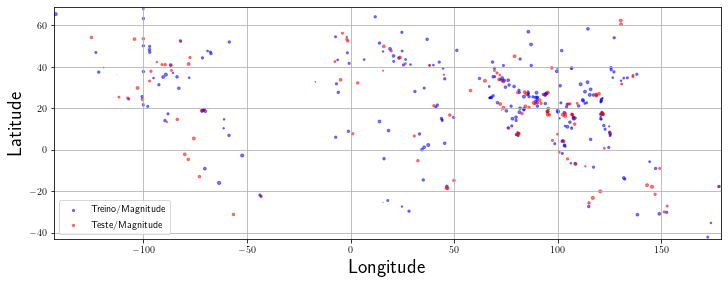

In [16]:
FS = (10,10) #Tamanho da figura a ser gerada
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0,0])

ax.scatter( xD[:,0], xD[:,1], s=xD[:,5]*10, c='blue', alpha=0.5, label='Treino/Magnitude')
ax.scatter( xI[:,0], xI[:,1], s=xI[:,5]*10, c='red', alpha=0.5, label='Teste/Magnitude')
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)

ax.set(xlim=(np.min(xD[:,0])-1,np.max(xD[:,0])+1), ylim=(np.min(xD[:,1])-1,np.max(xD[:,1])+1))
ax.set_aspect('equal', 'box')

ax.legend(fontsize=10)
ax.grid(True)

## Visualizacão dos dados de treino/classe

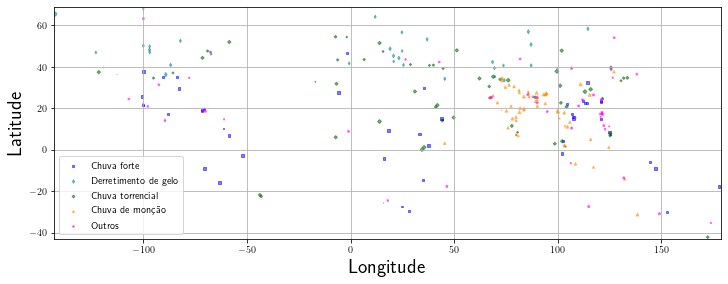

In [17]:
#Usado na estilização do gráfico
indClasse = [1,2,3,4,5]
cores = ['blue', 'darkcyan', 'darkgreen', 'darkorange', 'magenta']
simbolos = ['s', 'd', 'D', '^', '*']
nomes = ['Chuva forte', 'Derretimento de gelo', 'Chuva torrencial', 'Chuva de monção', 'Outros']

FS = (10,10) #Tamanho da figura a ser gerada
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0, 0])

for i,cor,simb,rotulo in zip(indClasse,cores,simbolos,nomes):
    pos = np.where(yD == i)[0]
    ax.scatter( xD[pos,0], xD[pos,1], s=xD[pos,5]*10, c=cor, marker=simb, alpha=0.5, label=rotulo)
    
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)

ax.set(xlim=(np.min(xD[:,0])-1,np.max(xD[:,0])+1), ylim=(np.min(xD[:,1])-1,np.max(xD[:,1])+1))
ax.set_aspect('equal', 'box')

ax.legend()
ax.grid(True)

## Classificação dos dados
#### Parâmetros:
* $\texttt{k}$: número de neurônios na camada escondida
* $\texttt{epsilon}$: citério de convergência usado pelo método K-Médias (além de 1000 iterações)

In [40]:
#Arquiteturas consideradas
k = 10
epsilon = 0.05

#0- Longitude, 1 - Latitute, 
#2 - Severidade, 3 - Duração (dias), 4- Área afetada (𝑘𝑚2), 5 - Magnitude
atributos = [2,3,4,5] #Permite escolhar qual atributo usar
xD_sub = xD[:,atributos]
xI_sub = xI[:,atributos]


#Treinamento...
W, cent, campo = train_rbf_net(xD_sub,yD,k,epsilon)

[[0.         0.00869565 0.00258583 0.15907666]
 [0.         0.03478261 0.33949212 0.66888485]
 [0.04761905 0.06086957 0.01477248 0.46799941]
 [0.         0.02608696 0.02224896 0.40559683]
 [0.04761905 0.0173913  0.01188502 0.36096425]
 [0.         0.06956522 0.07424913 0.58556191]
 [0.04761905 0.07826087 0.06895544 0.6247687 ]
 [0.         0.03478261 0.13960383 0.58930218]
 [0.         0.         0.01619903 0.25325476]
 [0.         0.00869565 0.00258583 0.15907666]]


## Avaliação do desempenho
* Análise baseada na concordância (%) entre Predição $vs$ Esperado.

In [41]:
#Predição efetuada por cada uma das redes
N = yI.shape[0]

yEst = np.zeros(N)
for i in range(0,N):
    padrao = xI_sub[i,:]
    yEst[i] = class_rbf_net(padrao, cent, campo, W)
    
#Concordâncias...
concord_g = np.count_nonzero(yEst == yI) / yI.shape[0]

print('Acurácia: ', concord_g)

Acurácia:  0.36220472440944884


## Qual classe acerta/erra mais? (com relação à melhor classificação acima)

In [10]:
for i,rotulo in zip(indClasse,nomes):
    posClasse = np.where(yI == i)[0]
    acc = np.count_nonzero(yEst[posClasse] == yI[posClasse]) / yI[posClasse].shape[0]
    print(rotulo,': ',str(acc*100),'')

Chuva forte :  0.0 
Derretimento de gelo :  0.0 
Chuva torrencial :  82.75862068965517 
Chuva de monção :  34.48275862068966 
Outros :  27.027027027027028 
